In [1]:
import torch
import pandas as pd
import numpy as np
from torch import nn
import torch.nn.functional as F
import h5py
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import time
import os

from losses import ssim as ssim_criterion
from losses import depth_loss as gradient_criterion
from dataset import getTrainingTestingData, loadZipToMem
from utils import DepthNorm
from model import UNet
import os
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

In [2]:
model = UNet()

In [3]:
# Load data
print("Loading Data ...")
trainloader, testloader = getTrainingTestingData(os.path.expanduser("~/Projects/data/NYU_DepthV2/data/nyu_depth.zip"), batch_size=4)
print("Dataloaders ready ...")
num_trainloader = len(trainloader)
num_testloader = len(testloader)

Loading Data ...
Loading dataset zip file...Loaded (50688).
1600 400
Dataloaders ready ...


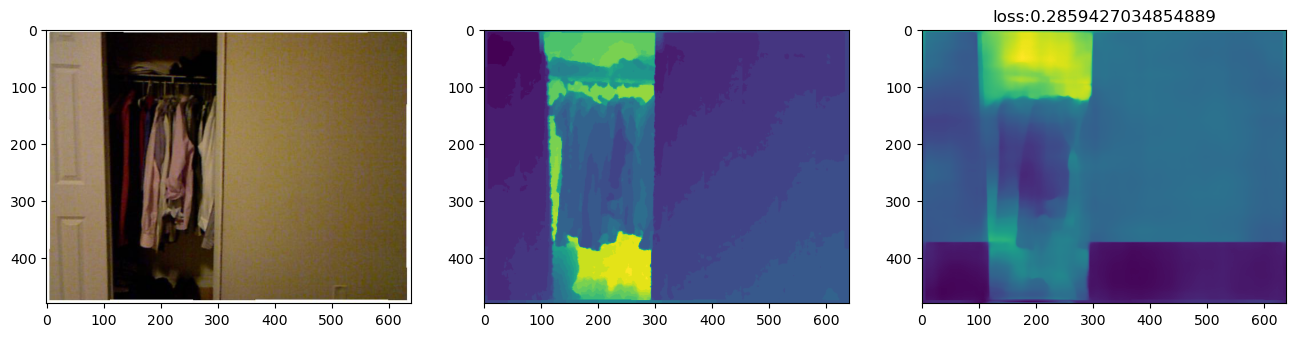

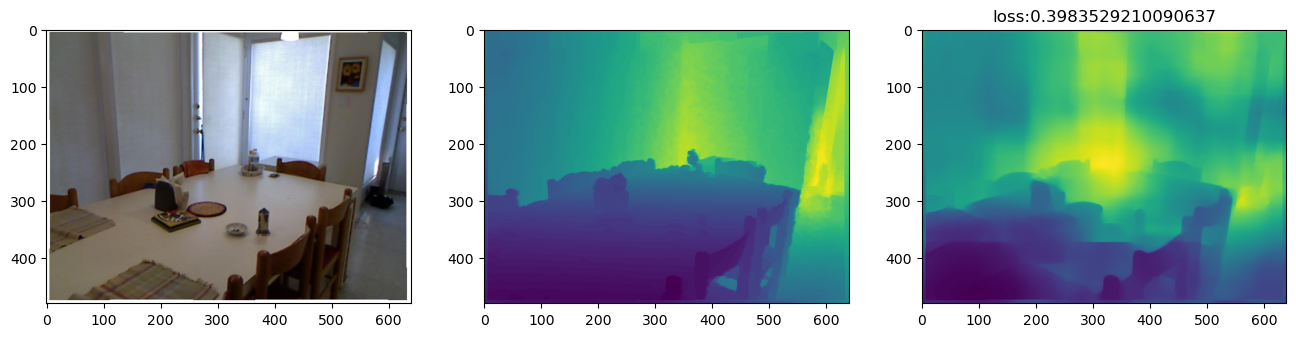

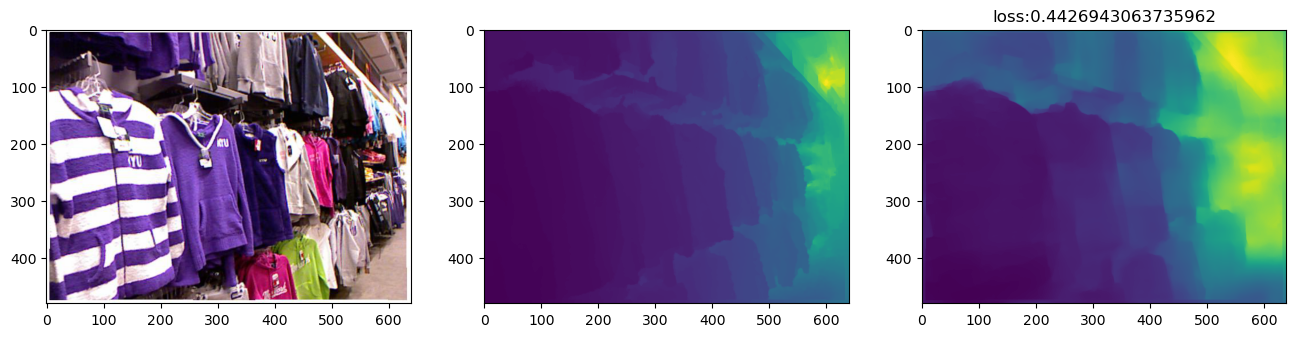

In [5]:
model.load_state_dict(torch.load("epoch_60.pt")['model_state_dict'])
model.eval()
l1_criterion = torch.nn.L1Loss()

with torch.no_grad():
    batch = next(iter(testloader))
    image_x = batch["image"]
    depth_y = batch["depth"]
    for i in range(3):
        out = model(image_x[i].unsqueeze(0))
        normalized_depth_y = DepthNorm(depth_y[i])

        preds = model(image_x[i].unsqueeze(0))

        # calculating the losses
        l1_loss = l1_criterion(preds, normalized_depth_y)

        ssim_loss = torch.clamp(
            (1 - ssim_criterion(preds, normalized_depth_y, 1000.0 / 10.0)) * 0.5,
            min=0,
            max=1,
        )

        gradient_loss = gradient_criterion(normalized_depth_y.unsqueeze(0), preds, device='cpu')

        net_loss = (
            (1.0 * ssim_loss)
            + (1.0 * torch.mean(gradient_loss))
            + (0.1 * torch.mean(l1_loss))
        )
        cpu_loss = net_loss.cpu().detach().numpy()
        fig,ax = plt.subplots(1,3,figsize=(16,8))
        ax[0].imshow(image_x[i].permute(1,2,0).cpu())
        ax[1].imshow(depth_y[i][0].cpu())
        ax[2].imshow(DepthNorm(out.cpu()[0][0]))
        ax[2].set_title(f"loss:{net_loss}")
        fig.savefig(f'test_img{i}_epoch_{0}.png')

In [6]:
img = Image.open("kitch.jpg")
img = transforms.ToTensor()(img)
with torch.no_grad():
    out = model(img.unsqueeze(0))

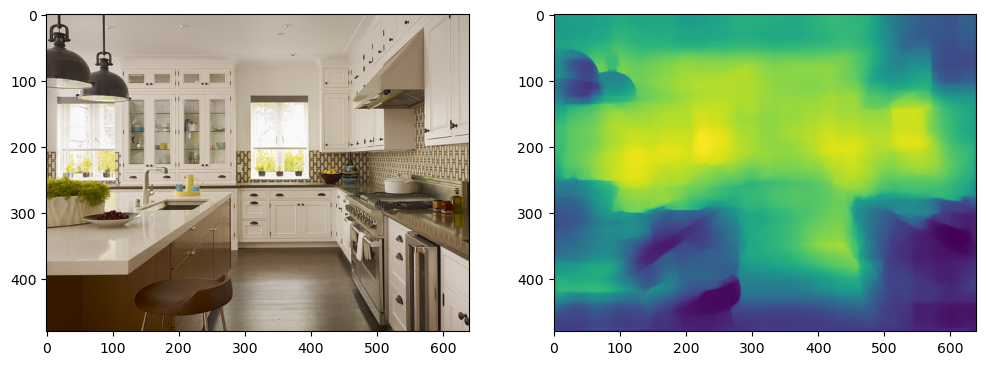

In [7]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].imshow(img.permute(1,2,0))
ax[1].imshow(DepthNorm(out[0][0]))